In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, ExpSineSquared, DotProduct, Matern

In [2]:
cum_casos = pd.read_csv('Data/cum_casos.csv')
cum_casos

,Data,cum_casos
0,2020-01-02,1
1,2020-01-04,3
2,2020-01-06,4
3,2020-01-07,5
4,2020-01-09,6
...,...,...
467,2021-06-27,26542
468,2021-06-28,26580
469,2021-06-29,26600
470,2021-06-30,26633


Text(0.5, 1.0, 'COVID-PB')

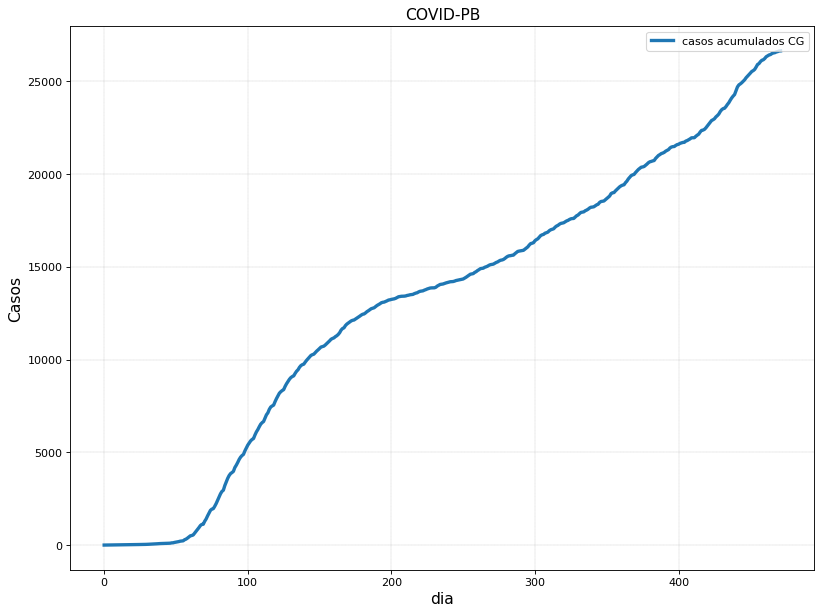

In [4]:
data = np.array(cum_casos.cum_casos.values)
data = data.reshape(-1, 1)

# escalona valores por milhares
CRdata = data/1000
CRdata  = np.ravel(CRdata)


# Visualizando o número de casos ao longo dos dias

plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data, linewidth = 3)
plt.legend(['casos acumulados CG'])
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

In [5]:
# Definição do dataset de teste
trainL = len(CRdata) - 30

# Linha do tempo (entrada do modelo) e dados (saída do modelo)
t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(t),1)
t = np.atleast_2d(t)

# Define intervalo de treinamento
t_tr  = t[0:trainL]
t_test = t[trainL:]

CR_tr = CRdata[0:trainL]
CR_test = CRdata[trainL:]

In [5]:
# Definição da função para diminuir dataset de treino
# n/2 -> pegamos apenas os indices pares do array
def half_data(data, time):
    half_data = []
    half_time = []
    for i,item in enumerate(data):
        if i%2 == 0:
            half_data.append(item)
            half_time.append(time[i])

    return np.array(half_data), np.array(half_time)


    

Modelagem GPR Para o número de casos acumulados

In [6]:
def GPR_Model(CR_tr, t_tr, CR_test, t_test):
    
    # Ajuste nas variáveis totais: t representa o conjunto treino + teste, assim como CRdata
    t = np.append(t_tr, t_test).reshape(-1,1)
    CRdata = np.append(CR_tr, CR_test)

    # Define kernel a ser utilizado
    #kernel = ConstantKernel()* Matern(1.0)*RBF() + DotProduct()
    kernel = ConstantKernel()*RBF()*DotProduct(sigma_0 = 0)*ConstantKernel(constant_value= 0.005)
    # kernel = RBF()
    # kernel = Matern()

    # Instancia classe GPR
    model  = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha = 10, normalize_y=False)

    # Treinamento do modelo
    model.fit(t_tr, CR_tr)
    print("\nLearned kernel: %s" % model.kernel_)
    params = model.kernel_.get_params()

    # Calcula R2 do modelo:
    R2_tr  = model.score(t_tr, CR_tr)
    R2     = model.score(t, CRdata)
    R2_test = model.score(t_test, CR_test)
    # Previsões do modelo
    CRpred_tr, sigma_tr = model.predict(t_tr, return_std=True) # previsão no intervalo de treinamento
    CRpred_test, sigma_test = model.predict(t_test, return_std=True) # previsão no intervalo de teste
    CRpred, sigma   = model.predict(t, return_std=True)    # previsão para todo o intervalo de dados

    MSE = np.mean(((CRpred_tr-CR_tr)*1000)**2)
    print("\nMSE: %f" % MSE)
    print("\nSTD: %f" % np.sqrt(MSE))
    print("\nR2 treinamento: %f" % R2_tr)
    print("\nR2 todo intervalo de dados: %f" % R2)
    print("\nR2 de teste: %f" % R2_test)

    return CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata


In [7]:
CRpred_tr, sigma_tr, CRpred_test, sigma_test, CRpred, sigma, t, CRdata = GPR_Model(CR_tr, t_tr, CR_test, t_test)

/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:271: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))



Learned kernel: 0.136**2 * RBF(length_scale=119) * DotProduct(sigma_0=0.000192) * 0.375**2

MSE: 77709.787979

STD: 278.764754

R2 treinamento: 0.998545

R2 todo intervalo de dados: 0.997440

R2 de teste: -2.639205


In [9]:
def plot_GPR(CRdata, CRpred, sigma, t):
    plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
    mpl.style.use('default')
    plt.plot(t, CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
    # plt.plot(t_tr, CR_tr*1000, 'k.', markersize=9, label='Dados de treinamento')
    plt.axvline(x = t_test[0],linestyle= '--', color = 'black')
    plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)
    plt.fill(np.concatenate([t, t[::-1]]),
            np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                            (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
            alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
    plt.legend(loc='upper left', fontsize = 14)
    #plt.ylim(0, 100e3)
    #plt.xlim(1, np.size(t) + 20)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylabel('Total de casos', fontsize = 14)
    plt.xlabel('dia', fontsize = 14)
    plt.title('COVID-CG Casos Acumulados', fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    

In [17]:
t

array([[  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.],
       [ 21.],
       [ 22.],
       [ 23.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 27.],
       [ 28.],
       [ 29.],
       [ 30.],
       [ 31.],
       [ 32.],
       [ 33.],
       [ 34.],
       [ 35.],
       [ 36.],
       [ 37.],
       [ 38.],
       [ 39.],
       [ 40.],
       [ 41.],
       [ 42.],
       [ 43.],
       [ 44.],
       [ 45.],
       [ 46.],
       [ 47.],
       [ 48.],
       [ 49.],
       [ 50.],
       [ 51.],
       [ 52.],
       [ 53.],
       [ 54.],
       [ 55.],
       [ 56.],
       [ 57.],
       [ 58.],
       [ 59.],
       [ 60.],
       [ 61.],
       [ 62.],
       [ 63.],
       [ 64.],
       [ 65.],
       [ 66.],
       [ 6

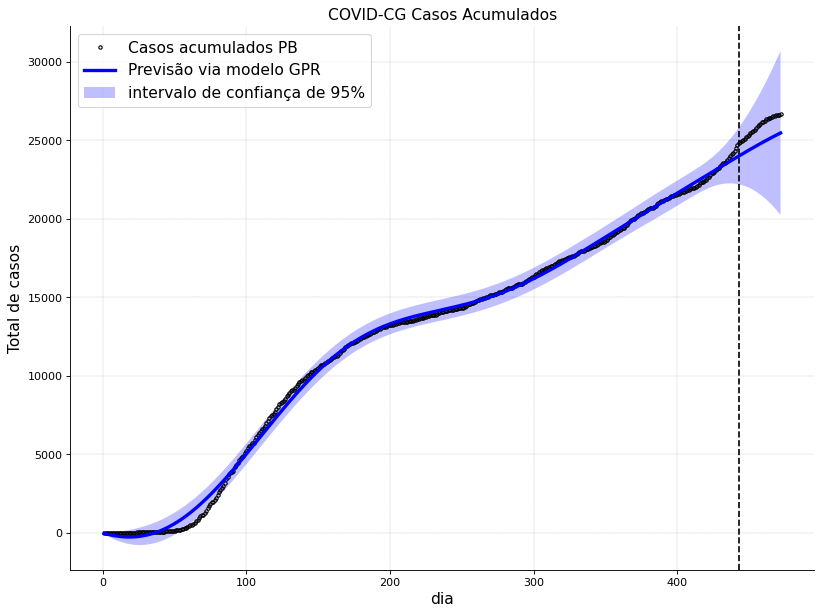

In [10]:
plot_GPR(CRdata, CRpred, sigma, t)


# Analisando para metade dos dados

In [10]:
CR_tr_half,t_tr_half = half_data(CR_tr, t_tr)

In [11]:
CRpred_tr_half, sigma_tr_half, CRpred_test_half, sigma_test_half, CRpred_half, sigma_half, t_half, CRdata_half = GPR_Model(CR_tr_half, t_tr_half, CR_test, t_test)


Learned kernel: 1.51**2 * Matern(length_scale=1.28e+04, nu=1.5) * RBF(length_scale=58.9) + DotProduct(sigma_0=1e-05)

MSE: 123648.727836

STD: 351.637211

R2 treinamento: 0.997685

R2 todo intervalo de dados: 0.997061

R2 de teste: -1.014164


/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


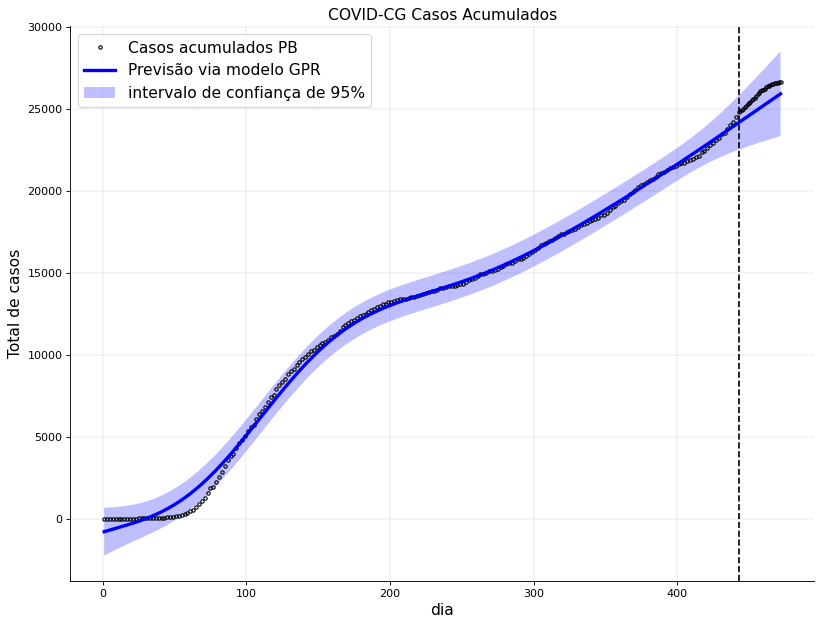

In [95]:
plot_GPR(CRdata_half, CRpred_half, sigma_half, t_half)


# Análise para 1/4 dos dados

In [12]:
CR_tr_quarter,t_tr_quarter = half_data(CR_tr_half, t_tr_half)
CRpred_tr_quarter, sigma_tr_quarter, CRpred_test_quarter, sigma_test_quarter, CRpred_quarter, sigma_quarter, t_quarter, CRdata_quarter = GPR_Model(CR_tr_quarter, t_tr_quarter, CR_test, t_test)



Learned kernel: 1.4**2 * Matern(length_scale=1e+05, nu=1.5) * RBF(length_scale=61.3) + DotProduct(sigma_0=0.00453)

MSE: 261714.232044

STD: 511.580133

R2 treinamento: 0.995140

R2 todo intervalo de dados: 0.995290

R2 de teste: -0.828924


/home/andre/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


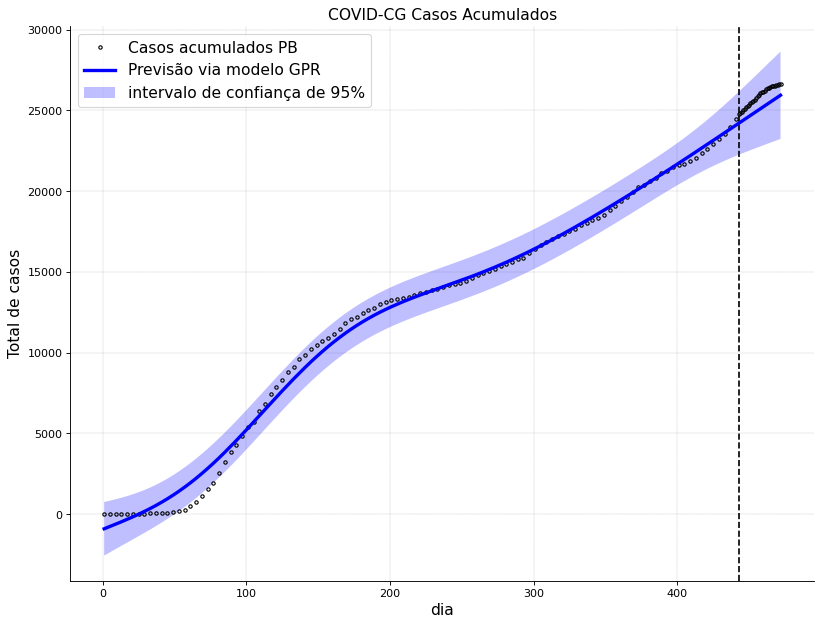

In [98]:
plot_GPR(CRdata_quarter, CRpred_quarter, sigma_quarter, t_quarter)


# Modelagem Utilizando Rede Neural


In [192]:
from sklearn.neural_network import MLPRegressor

# Treinamento da rede neural
regr = MLPRegressor(random_state=1, max_iter=500, activation= 'relu', hidden_layer_sizes=(100)).fit(t_tr, CR_tr)

# Calcula R2 do modelo:
R2_tr_nn  = regr.score(t_tr, CR_tr)
R2_nn     = regr.score(t[0:len(CRdata)], CRdata)
R2_test_nn = regr.score(t[trainL:len(CRdata)], CRdata[trainL:])
# Previsões do modelo
CRpred_nn_tr = regr.predict(t_tr) # previsão no intervalo de treinamento
CRpred_nn   = regr.predict(t)    # previsão para todo o intervalo de dados
   
MSE = np.mean(((CRpred_nn_tr-CR_tr)*1000)**2)
print("\nMSE: %f" % MSE)
print("\nSTD: %f" % np.sqrt(MSE))
print("\nR2 treinamento: %f" % R2_tr_nn)
print("\nR2 todo intervalo de dados: %f" % R2_nn)
print("\nR2 de teste: %f" % R2_test_nn)



MSE: 386387.038379

STD: 621.600385

R2 treinamento: 0.992768

R2 todo intervalo de dados: 0.992658

R2 de teste: -2.768164


/home/andre/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


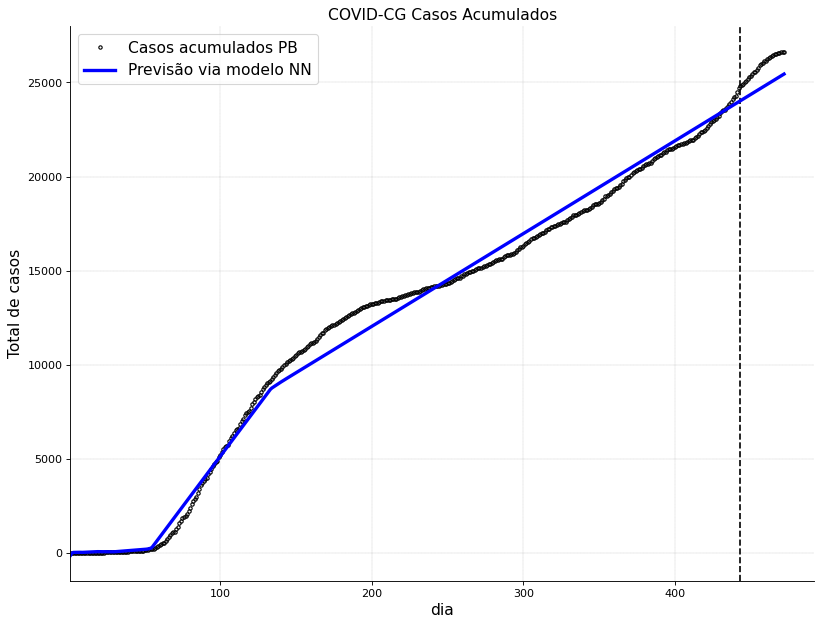

In [193]:
# Plota resultados da rede neural
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t[0:len(CRdata)], CRdata*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
# plt.plot(t_tr, CR_tr*1000, 'k.', markersize=9, label='Dados de treinamento')
plt.axvline(x = t[trainL],linestyle= '--', color = 'black')
plt.plot(t, CRpred_nn*1000, 'b-', label='Previsão via modelo NN', linewidth = 3)
# plt.fill(np.concatenate([t, t[::-1]]),
#          np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
#                         (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
#          alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-CG Casos Acumulados', fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)